We first need to import some libraries to use, as well as moving the working directory to the folder containing the raw data .csv files: In my case this is ../Swallows/ :

In [2]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

path_root="/Users/domansa/Documents/BiodiversityAnalysis/Data/NBN_downloads/Swallows/"
os.chdir(path_root)

For the mapping visualisations, we also need to grab the outline of the UK for the map: 
the easiest way to do this is using geopandas' 'naturalearth_lowres' basemap:


In [3]:

import geopandas
import geoplot

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

Downloads from NBN are limited to 500k observations, ours are at least 1.1M records:  so we need to first recombine all the downloaded .csv files into a single file, called 'combinedSwallows.csv'. Grab a cup of tea, this might take a while...

In [ ]:
# list all .csv files in the folder:
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
all_filenames.sort(key=str.lower) # sort by name, not strictly necessary

# load all files in list, then concatenate into a single pandas datagrame 
combined_csv = pd.concat([pd.read_csv(f,low_memory=False) for f in all_filenames ])

# export as one concatenated csv file
combined_csv.to_csv( "combinedSwallows.csv", index=False, encoding='utf-8-sig')

The data annotations offered by NBN are very rich - most of this we don't need at this point.
Let's grab just the key information (dates, locations for the sightings) and copy it into a new Pandas dataframe.

To compare days of the year, we also need to recast the day/month timestamps into a single number from 1~366 (accounting for leap years). We'll add this as a new column in the dataframe.

We also want to know when they are arriving and departing with weekly resolution, so lets add this too:


In [5]:
combined_csv = pd.read_csv('combinedSwallows.csv') 
Swallows= combined_csv[["eventDate processed",
                        "year processed",
                        "month processed",
                        "day processed",
                        "decimalLatitude processed",
                        "decimalLongitude processed"]]

# Get the day of the year
# NB this will jump a bit for leap years! @TODO: fix this annotation
Swallows["day_of_year"] = pd.to_datetime(Swallows["eventDate processed"]).dt.dayofyear

# Get the week of the year
Swallows["week"]        = pd.to_datetime(Swallows["eventDate processed"]).dt.week

# Take a peek at the first few entries:
Swallows.head()

/Users/domansa/opt/anaconda3/envs/GIS/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (30,38,50,60,61,63,64,66,92,95,100,103) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/var/folders/cn/s64wmd7x6c941ldy0w5mmbjjkq4rlk/T/ipykernel_80521/1982031947.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Swallows["day_of_year"] = pd.to_datetime(Swallows["eventDate processed"]).dt.dayofyear
/var/folders/cn/s64wmd7x6c941ldy0w5mmbjjkq4rlk/T/ipykernel_80521/1982031947.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  Swallows["week"]        = pd.to_date

,eventDate processed,year processed,month processed,day processed,decimalLatitude processed,decimalLongitude processed,day_of_year,week
0,2003-06-17,2003,6,17,50.869364,-0.089932,168,25
1,1989-09-15,1989,9,15,53.409445,-1.332044,258,37
2,2005-05-04,2005,5,4,51.878147,1.267519,124,18
3,2005-04-13,2005,4,13,50.231839,-3.845106,103,15
4,2009-07-25,2009,7,25,50.515435,-2.445646,206,30


Let's do a sanity check and take a quick look to see the spatial distribution of the data. We'll use Panda's overloaded plotting functionality for this:

(-9.188033461519275, 2.3312424615192757, 49.312935350000004, 61.38428365)

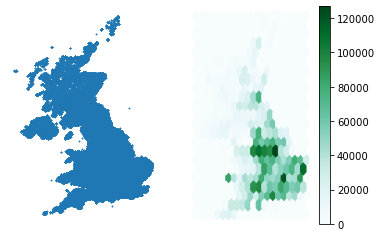

In [6]:
# Quick and dirty plotting and binning of the data points

fig, axs = plt.subplots(1,2)

ha1 = Swallows.plot.scatter(x='decimalLongitude processed',
                            y='decimalLatitude processed',ax=axs[0],s = 0.1)
axs[0].axis('off')

ha2 = Swallows.plot.hexbin(x='decimalLongitude processed',
                            y='decimalLatitude processed',ax=axs[1],gridsize=20)
axs[1].axis('off')

Let's begin by plotting some animations of the data through time. 
There are more elegant tools for this but this is easiest to get working.
We will create one low resolution figure for each day, looping over years and each day
Each day's plot is saved to an output folder and will become one movie frame.

N.B. We need to make a new folder before running each of the blocks of code below:
- one called /plots 
- one called /heatmap

This can be done programatically, but we'll allow the user to stay in control this time.

Run the cell below, and then check that a series of .png plots has appeared in the /plots folder.
To turn the individual pictures into a .GIF, we'll use imagemagick - download this first before the following line will work.

Then, ouside python, open a terminal (bash, Windows Powershell etc.), navigate to the output directory using ```cd``` and run the following:

```convert -delay 50 -dispose previous birdDist*.png animated_Swallows.gif```


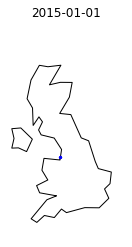

In [ ]:
# %%capture --no-display # Hide the warning outputs

# scatter the report data, loop over years and days for each plot, plot each bird sighting by coordinates

# Outer loop is years, inner loop is days.
# We'll only plot a restricted time range of 2015~2021, to get all included date ranges, you can use this instead
# for counter, year in enumerate(sorted(list(pd.unique(Swallows['year processed'])))):
#     for day_counter, enumerate(sorted(list(pd.unique(Swallows['day_of_year'])))):
        
for counter, year in enumerate(np.arange(2015,2021)):      
    for day_counter, day in enumerate(np.arange(1,365)):   
        # index out the relevant data:         
        data_sub = Swallows[(Swallows['year processed'] == year) & (Swallows['day_of_year'] == day)]

        # skip this day if there's no sighting data:
        if data_sub.shape[0] == 0:
            continue

        # Plot the outline of the UK using the underlying shapely geometry from the 'world' mapping object
        ax = world[world.name == 'United Kingdom'].plot(color='white', edgecolor='black')  

        # Convert the Lat and Long info to a geopandas dataframe, using the 'EPSG:4326' coordinate ref system (crs)
        gdf = geopandas.GeoDataFrame(data_sub, 
                                     geometry=geopandas.points_from_xy(
                                        data_sub['decimalLongitude processed'], 
                                        data_sub['decimalLatitude processed']),
                                    crs='EPSG:4326')
        
        # Scatter plot the bird sightings, make them transparent-ish with a bit of 'alpha' 
        gdf.plot(ax=ax, alpha=0.2, markersize=5, c='b')
        
        # Stop the map jumping around by fixing the lat and long corners of the plot:
        plt.xlim([-8, 3])
        plt.ylim([49, 61])
        
        # Use the date as the title
        plt.title('%s' % (pd.unique(data_sub['eventDate processed'])[0]))        

        # Hide the bounding box
        plt.axis('off')
        
        # Save this figure as a new figure at 100dpi resolution
        plt.savefig(path_root + 'plot/birdDist_%s_%d.png' % (year, day), dpi=100)
        plt.close() # Optionally remove the plot to stop the accumulating in the output below


We can run the same approach but using a different plotting command to get a smoothed heatmap for each plot instead of a scatterplot. These will be saved to the /heatmap folder:

/var/folders/cn/s64wmd7x6c941ldy0w5mmbjjkq4rlk/T/ipykernel_80521/2856386775.py:23: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  data_sub.total_bounds = [-8, 49,3,61]
/Users/domansa/opt/anaconda3/envs/GIS/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/domansa/opt/anaconda3/envs/GIS/lib/python3.8/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/Users/domansa/opt/anaconda3/envs/GIS/lib/python3.8/site-packages/seaborn/distributions.py:1106: UserWarning: Dataset

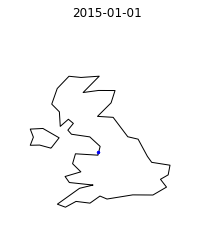

In [9]:
# %%capture --no-display # Hide the warning outputs

# This code block is as above, but uses a smoothed heatmap 'kernel density estimation' approach to summarise the data

for counter, year in enumerate(np.arange(2015,2021)):
    for day_counter, day in enumerate(np.arange(1,2)):
        data_sub = Swallows[(Swallows['year processed'] == year) & (Swallows['day_of_year'] == day)]

        if data_sub.shape[0] <10: # The KDE struggles with fewer than ten observations, so trip low count days
            continue
            
        ax = world[world.name == 'United Kingdom'].plot(color='white', edgecolor='black')  # the frame is turned off            

        gdf = geopandas.GeoDataFrame(data_sub, 
                                     geometry=geopandas.points_from_xy(
                                        data_sub['decimalLongitude processed'], 
                                        data_sub['decimalLatitude processed']),
                                     crs='EPSG:4326')


        gdf.plot(ax=ax, alpha=0.2, markersize=5, c='b')

        data_sub.total_bounds = [-8, 49,3,61]
        geoplot.kdeplot(data_sub,shade=True, cmap='Reds',ax=ax)
        plt.title('%s' % (pd.unique(data_sub['eventDate processed'])[0]))        
        plt.axis('off')

        plt.savefig(path_root + 'heatmap/birdDist_%s_%d.png' % (year, day), dpi=100)
    
        plt.close()

Now we have imported the data and have access to the spatial and timestamp data, let's look for annual trends in the data. To start, let's collapse sightings by month:

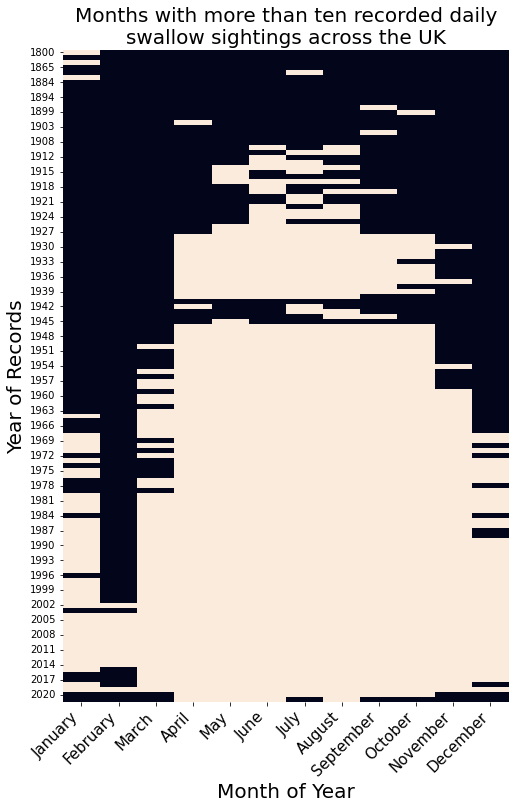

In [82]:
# Use pandas' crosstab function to count swallwo sightings by year x month
data = pd.crosstab(columns=Swallows['month processed'], index=Swallows['year processed'],normalize=False)

# We need to get the month names as column titles instead of 1~12. This is a quick way to do this
months =  [ datetime.date(1900, x, 1).strftime('%B') for x in np.arange(1,13)]
data.columns = months

# Plot a  heatmap , with black/white blocks indicating months with less/more than 5 swallow sighings across the UK
fig = plt.figure(figsize=(8, 12))
hm  = sns.heatmap(data>10, annot=False,cbar=False)

# Tidy the plot up
plt.ylabel('Year of Records', fontsize=20)
plt.xlabel('Month of Year', fontsize=20)
plt.xticks(rotation=45, fontsize=15,ha='right')

plt.title("""Months with more than ten recorded daily
swallow sightings across the UK""", fontsize=20)

# Save the figure as a .jpeg
plt.savefig(path_root + '/plot/Year by Month.jpeg', dpi=300)


This is the same process, but now narrowing into a weekly basis:

(0.0, 51.0)

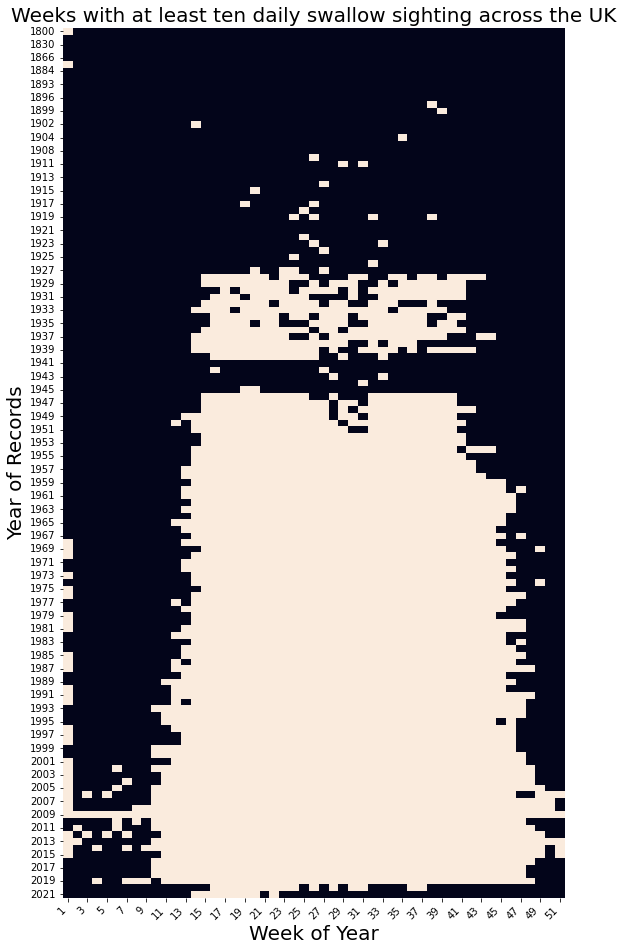

In [83]:
# count occurrence by year-week
data = pd.crosstab(columns=Swallows['week'], index=Swallows['year processed'],normalize=False)

# heatmap
fig = plt.figure(figsize=(9, 16))
hm = sns.heatmap(data>10, annot=False,cbar=False)

plt.ylabel('Year of Records', fontsize=20)
plt.xlabel('Week of Year', fontsize=20)
plt.xticks(rotation=45, fontsize=10,ha='right')
plt.title("""Weeks with at least ten daily swallow sighting across the UK""", fontsize=20)

plt.savefig(path_root + '/plot/Year by Week.jpeg', dpi=300)
plt.xlim([0,51])


It's clear that as we move down the Y axis (forward in time), that the span of the white blocks is increasing: This suggests that the timerange of weeks over which swallows are sighted in the UK is increasing on an annual basis. 

in order to quantify this, we need an objective measure of arrival and departure dates. let's try to automatically extract the annaul arrival and departure dates, with a weekly resolution.
- We'll threshold the data into yes/no sighings each week to get an array of Trues and Falses, one for each week. 

We then want to define motifs (i.e. temporal features) in the timeseries corresponding to consistent switches in observations that mark the arrival and departure periods.
-  It's usually easiest and fastest to do this on binary data by converting it to strings, and using string find methods.

We will search the weekly data to find the patterns. To do this, we'll assume the following abitrary motifs text to search for:
- Arrival = 'fftttt' ( two weeks of absence followed by a sustained presence)
- Departure = 'tttff' (Two weeks of presence followed by a sustained absence)

In [ ]:
# take the weekly sighting count across the UK for each year of observations
data = pd.crosstab(columns=Swallows['week'], index=Swallows['year processed'],normalize=False)

# Binarise the data: threshold by whether there were at least five sightings for each week of observation
sightingMatrix = (data>10) 

# Optionally convert True/False to 1/0
# sightingMatrix = sightingMatrix.astype('uint8') 

arrivalPattern = 'fftttt'
departurePattern = 'tttff'

# Here's a quick function to collapse the list of Trues and Falses into strings of t's and f's:
def bool_list_to_str(bool_list):
    return ''.join('ft'[i] for i in bool_list)

# Make a new dataframe to hold the detected week number for each of the arrival and departure times
Migration = pd.DataFrame(columns = ["Arrival", "Departure"])

# Now, apply our search function 'bool_list_to_str' to each year (row) of the binarised sighting matrix and catch the numbers into the relevant columns of the 'Migration' dataframe
Migration['Arrival']   = sightingMatrix.apply(lambda x: bool_list_to_str(x).find(arrivalPattern),axis =1) 
Migration['Departure'] = sightingMatrix.apply(lambda x: bool_list_to_str(x).find(departurePattern),axis =1) 

# Years with no detected motifs are returned with -1 by default. Let's replace with NaNs:
Migration = Migration.replace(-1, value=np.nan)

Now, we have a new Pandas dataframe called ```Migration```, containing the estimated week of the calendar year of arrival and departure for swallows across the UK. We can then use this to fit models make predicitions, and in the future, test for correlations and causal factors that might affect the animals' behaviour.

Let's plot the estimated Arrival and Departrue data and look for annual trends in the detected migration timepoints. We will use ```SciKit-Learn```, a popular machine learning library to fit a cross-validated linear regression (resistant to over-fitting) and use the fitted trends to predict the annual changes: 


In [ ]:
from sklearn import linear_model 
from sklearn.model_selection import train_test_split 

# We'll loop over arrival and departure events
events  = ['Arrival','Departure']

# Need to correct for the two week offset (in opposite directions) 
# This is where the detected jumps occur after the second week in the search templates above:
offset = [2,-2]

fig, axs = plt.subplots(1,2)

# Let's use SciKit learn to fit a simple ordinary least squares linear regression to work out the rate of change per annum for each of the Arrival and Departure timeseries:
ols=[linear_model.LinearRegression(),linear_model.LinearRegression()]

# ... Or optionally try ridge regression for a more robust fit:
# ols=[linear_model.Ridge(alpha=.1),linear_model.Ridge(alpha=.1)]

for counter, event in enumerate(events):
    # Grab some X and Y data to fit (years and detected week of change)
    X = Migration.index.values
    Y = Migration[event].values 

    # Trim off the years without detected arrival jumps  - the fitting can't handle the NaNs
    idx = np.isnan(Y)
    X = X[~idx].reshape(-1,1)
    Y = Y[~idx].reshape(-1,1)
    
    # Correct the week data for the template offsets:
    Y = Y + offset[counter] 

    # Split the datapoints into separate train/test sets for five-fold cross-validation 
    # (Really we only want the fit coeffs but it's good practice for estimating slopes):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
    
    # fit the regression model:
    ols[counter].fit(X_train,y_train)

    # Return the slope:
    # print(ols[counter].coef_) # In weekly change
    # print(abs(ols[counter].coef_[0]*7))# In daily change
    
    # Now predict the values for the witheld test data points
    y_pred = ols[counter].predict(X_test)
    
    # Get the slope of the regression line, convert from weekly to daily trend by multiplying by 7:
    slope = abs(ols[counter].coef_[0]*7)

    # Overlay the slope as text on the plot 
    axs[counter].text(1910,5,"Rate of change =") 
    axs[counter].text(1910,2,f'{slope[0]:.2f} days per year')

    # Plot the data and trends
    axs[counter].scatter(Migration.index.values, Migration[event].values+ offset[counter],  color='gray')
    axs[counter].plot(X_test, y_pred, color='red', linewidth=2)
    axs[counter].set_ylim([0,52]) 
    axs[counter].set_xlim([1900,2050]) 
        
    axs[counter].set_xlabel('Year of records')
    axs[counter].set_title('Annual ' + event.lower() + ' date')
    if (counter ==0):
        axs[counter].set_ylabel('Week of year')

    del X,Y,idx, X_train, X_test, y_train, y_test

# Save the figure
plt.savefig(path_root + '/plot/Yearly trend.jpeg', dpi=300)

Now, we have a new Pandas dataframe called Migration, containing the estimated week of the calendar year of arrival and departure for swallows across the UK. We can then use this to fit models make predicitions, and in the future, test for correlations and causal factors that might affect the animals' behaviour.

Let's plot the estimated Arrival and Departrue data and look for annual trends in the detected migration timepoints. We will use SciKit-Learn, a popular machine learning library to fit a cross-validated linear regression (resistant to over-fitting) and use the fitted trends to predict the annual changes:head

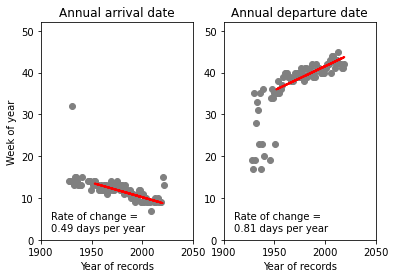

In [85]:
from sklearn import linear_model 
from sklearn.model_selection import train_test_split 

# We'll loop over arrival and departure events
events  = ['Arrival','Departure']

# Need to correct for the two week offset (in opposite directions) 
# This is where the detected jumps occur after the second week in the search templates above:
offset = [2,-3]

fig, axs = plt.subplots(1,2)

# Let's use SciKit learn to fit a simple ordinary least squares linear regression to work out the rate of change per annum for each of the Arrival and Departure timeseries:
ols=[linear_model.LinearRegression(),linear_model.LinearRegression()]

# ... Or optionally try ridge regression for a more robust fit:
# ols=[linear_model.Ridge(alpha=.1),linear_model.Ridge(alpha=.1)]

for counter, event in enumerate(events):
    # Grab some X and Y data to fit (years and detected week of change)
    X = Migration.index.values
    Y = Migration[event].values 

    # Trim off the years without detected arrival jumps  - the fitting can't handle the NaNs
    #Fit the data since 1960. Also ignore 2021 as we're not finished yet:
    idx = np.isnan(Y) | (X ==2021) | (X <1950)
    X = X[~idx].reshape(-1,1)
    Y = Y[~idx].reshape(-1,1)
    
    # Correct the week data for the template offsets:
    Y = Y + offset[counter] 

    # Split the datapoints into separate train/test sets for five-fold cross-validation 
    # (Really we only want the fit coeffs but it's good practice for estimating slopes):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
    
    # fit the regression model:
    ols[counter].fit(X_train,y_train)

    # Return the slope:
    # print(ols[counter].coef_) # In weekly change
    # print(abs(ols[counter].coef_[0]*7))# In daily change
    
    # Now predict the values for the witheld test data points
    y_pred = ols[counter].predict(X_test)
    
    # Get the slope of the regression line, convert from weekly to daily trend by multiplying by 7:
    slope = abs(ols[counter].coef_[0]*7)

    # Overlay the slope as text on the plot 
    axs[counter].text(1910,5,"Rate of change =") 
    axs[counter].text(1910,2,f'{slope[0]:.2f} days per year')

    # Plot the data and trends
    axs[counter].scatter(Migration.index.values, Migration[event].values+ offset[counter],  color='gray')
    axs[counter].plot(X_test, y_pred, color='red', linewidth=2)
    axs[counter].set_ylim([0,52]) 
    axs[counter].set_xlim([1900,2050]) 
        
    axs[counter].set_xlabel('Year of records')
    axs[counter].set_title('Annual ' + event.lower() + ' date')
    if (counter ==0):
        axs[counter].set_ylabel('Week of year')

    del X,Y,idx, X_train, X_test, y_train, y_test

# Save the figure
plt.savefig(path_root + '/plot/Yearly trend.jpeg', dpi=300)